In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
scaler = StandardScaler() 

## Importing Data

In [ ]:
#loading dataset
name= ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',delim_whitespace=True,names=name)

## Preprocessing

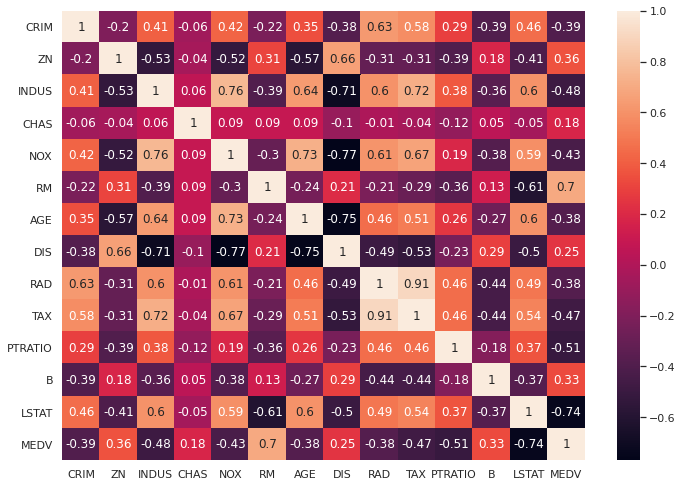

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_matrix = data_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True);

Removing RAD as RAD and TAX have correlation 0.91 , whereas Tax Correlation with the target variable MEDV is higher than RAD vs MEDV

In [ ]:
data_df.drop(columns="RAD",inplace=True)
data_np = data_df.to_numpy()


In [ ]:
scaler.fit_transform(data_np);

In [ ]:
x_train , x_test , y_train , y_test =  train_test_split(data_np[:,:-1],data_np[:,-1],test_size=0.2,shuffle=True)

#### Creating Function

##### Function to calculate metrics

In [ ]:
### Code for metrics Calculation
def metrica(model , x_train , y_train , x_test , y_test,p,lambda_= None):
    regressor = model(lambda_)                #Initializing Model
    regressor.fit(x_train,y_train)            #Fitting Model
    prediction = regressor.predict(x_test)    # Predicting Model

    # Calculatiog metrics RMSE and R^2

    rmse =  metrics.mean_squared_error(y_test,prediction,squared=False)
    r2 = metrics.r2_score(y_test,prediction)

    if p == True:
        return print( "RMSE is " + str(rmse) + " and R^2 is " + str(r2) )
    else:
        return np.array([rmse , r2])

##### Function for Cross Validation

In [ ]:
class cv_model:
    def __init__(self,model,data,fold,lambda_=None):
        self.model = model
        self.X  = data[:,:-1]
        self.y  = data[:,-1]
        self.fold  = fold
        self.lambda_ = lambda_

    def compute(self):
        kf = KFold(n_splits=self.fold)
        regressor = self.model(self.lambda_)
        a = np.empty(self.fold,dtype=np.float64)
        b = np.empty(self.fold,dtype=np.float64)
        count = -1
        for train_index, test_index in kf.split(self.X):
            count = count +1
            X_train, X_test = self.X[train_index], self.X[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            regressor.fit(X_train,y_train)
            prediction = regressor.predict(X_test)
            rmse_ =  metrics.mean_squared_error(y_test,prediction,squared=False)
            r2_ = metrics.r2_score(y_test,prediction)
            a[count]=rmse_
            b[count]=r2_
        self.rmse = a
        self.r2 = b
        return self

## MLR

We are going to use the following formula

$$\beta = (X^TX)^{-1}X^TY$$



In [ ]:
class MLR:
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        
    def fit(self,x,y):
        x = np.c_[np.ones(x.shape[0]),x]
        x_transpose = x.transpose()    # Transpose of x_train
        x_t_x = np.matmul(x_transpose,x)
        x_t_x_inv = np.linalg.inv(x_t_x)
        self.beta = np.matmul(np.matmul(x_t_x_inv,x_transpose),y)
        return self

    def predict(self,x_test):
        x_test = np.c_[np.ones(x_test.shape[0]),x_test]
        return np.matmul(x_test,self.beta)

In [ ]:
metrica(MLR,x_train,y_train,x_test,y_test,p=True)

RMSE is 5.029560109311133 and R^2 is 0.7468974313189258


## Cross Validation for MLR

In [ ]:
cv_MLR = cv_model(MLR,data_np,5)
cv_MLR.compute();


In [ ]:
print("Mean of RMSE is "+ str(cv_MLR.rmse.mean())+" and R^2 is " + str(cv_MLR.r2.mean()))

Mean of RMSE is 5.646495591640052 and R^2 is 0.43281695769829004


## Ridge


$\beta_{Ridge} = (X^TX+\lambda I)^{-1}X^Ty $

In [ ]:
class ridge:
    def __init__(self, lambda_):
        self.lambda_ = lambda_

    def fit(self,x,y):
        x = np.c_[np.ones(x.shape[0]),x]
        x_transpose = x.transpose()    # Transpose of x_train
        x_t_x = np.matmul(x_transpose,x)
        x_t_x_l_inv = np.linalg.inv(x_t_x+self.lambda_ * np.identity(x_t_x.shape[1]))
        self.beta = np.matmul(np.matmul(x_t_x_l_inv,x_transpose),y)
        return self

    def predict(self,x_test):
        x_test = np.c_[np.ones(x_test.shape[0]),x_test]
        return np.matmul(x_test,self.beta)


In [ ]:
metrica(ridge,x_train,y_train,x_test,y_test,p=True,lambda_=0.11)

RMSE is 5.051881107510282 and R^2 is 0.7446459270143345


In [ ]:
# plot_rmse(model,x_train,y_train,x_test,y_test):
#    fun = lambda lambda_: metrica(model,x_train,y_train,x_test,y_test,p=False,lambda_=1)[0]
#    x = np.arange(100)*0.1
#    y = np.array(list(map(fun,x)))
#    plt.plot(x,y)
#    plt.xlim(4,5)
#    plt.show

## Cross Validation for Ridge

In [ ]:
cv_ridge = cv_model(ridge,data_np,5,lambda_=1) 
cv_ridge.compute();

In [ ]:
print("Mean of RMSE is "+ str(cv_ridge.rmse.mean())+" and R^2 is " + str(cv_ridge.r2.mean()))

Mean of RMSE is 5.4037807572537435 and R^2 is 0.4631197305849663


## Lasso




In [ ]:
metrica(Lasso,x_train,y_train,x_test,y_test,p=True,lambda_=0.11)

RMSE is 5.170541136097597 and R^2 is 0.732509389253974


## Cross Validation on Lasso

In [ ]:
cv_lasso = cv_model(Lasso,data_np,5,lambda_=0.11) 
cv_lasso.compute();

In [ ]:
print("Mean of RMSE is "+ str(cv_lasso.rmse.mean())+" and R^2 is " + str(cv_lasso.r2.mean()))

Mean of RMSE is 5.575971581728931 and R^2 is 0.44683633521419186


## k-NN Regressor

In [ ]:
metrica(KNeighborsRegressor , x_train , y_train , x_test , y_test,p=True,lambda_= 6)

RMSE is 6.549424337323608 and R^2 is 0.5708167090369125


##### Cross Validation for k-NN Regressor

In [ ]:
cv_knn = cv_model(KNeighborsRegressor,data_np,5,lambda_=9) 
cv_knn.compute();


In [ ]:
print("Mean of RMSE is "+ str(cv_knn.rmse.mean())+" and R^2 is " + str(cv_knn.r2.mean()))

Mean of RMSE is 8.494103604120602 and R^2 is -0.28140088739374924


#### Tree Ensemble using XG Boost

In [ ]:
import xgboost as xgb
model = lambda lambda_ : xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 2, n_estimators = 100)

In [ ]:
metrica(model,x_train,y_train,x_test,y_test,p=True,lambda_=None)

RMSE is 3.694576654016938 and R^2 is 0.8634266663815804


### Cross Validation for XGBoost

In [ ]:
cv_xgb = cv_model(model,data_np,6,lambda_=9) 
cv_xgb.compute();

In [ ]:
print("Mean of RMSE is "+ str(cv_xgb.rmse.mean())+" and R^2 is " + str(cv_xgb.r2.mean()))

Mean of RMSE is 4.571726101213414 and R^2 is 0.6085690036011154


# COBRA

Taking the following Machines in Consideration

1. $r_1$ = MLR
2. $r_2$ = Ridge
3. $r_3$ = Lasso
4. $r_4,r_5,r_6,r_7$ = k-NN with 5,10,15, and 20 Neighbors
5. $r_8,r_9,r_{10},r_{11},r_{12}$ = Tree Ensemble with 20,40,60,80,100 Trees

In [ ]:
class COBRA:
    def __init__(self, lambda_):
        self.eta = lambda_
        
    def fit(self,x,y):
        r_1 = MLR(lambda_=None)
        r_2 = ridge(lambda_=1)
        r_3 = Lasso(alpha = 1)
        
        r_7 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 2, n_estimators = 20)
        r_8 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 2, n_estimators = 40)
        r_9 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 2, n_estimators = 60)
        r_10 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 2, n_estimators = 80)
        r_11 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 2, n_estimators = 100)
        machines = [r_1,r_2,r_3,r_8,r_7,r_9,r_10,r_11]
        train_predict = []
        for machine in machines:
            machine.fit(x,y)
            train_predict.append(machine.predict(x))
        self.machines = machines
        self.train_predict = np.transpose(np.array(train_predict))
        return self


    def predict(self,x_test):
        test_predict  = []
        for machine in self.machines:
            test_predict.append(machine.predict(x_test))
        test_predict = np.transpose(np.array(test_predict))

        prediction = []
        for row in test_predict:
            m = []
            count=-1
            row_0 = np.array(row)-self.eta
            row_1 = np.array(row)+self.eta
            for rowii in self.train_predict:
                count = count+1
                rowii = np.array(rowii)
                if all(rowii > row_0) and all(rowii < row_1):
                    m.append(y_train[count])
            prediction.append(np.array(m).mean())
        return np.array(prediction)

In [ ]:
metrica(COBRA , x_train , y_train , x_test , y_test,p=True,lambda_= 9)

RMSE is 3.869114646978659 and R^2 is 0.8502179589679689


## Summary

| Method | RMSE | $R^2$ |
| :- | :- | :-: |
| MLR | 5.0295 | 0.7468
| Lasso | 5.0518 | 0.7325
| Ridge | 5.1705 | 0.7325
| k-NN | 6.5494 | 0.57081
| XG Boost | 3.6945 | 0.8634
| COBRA | 3.8691 | 0.8502

#### Cooks Distance Using MLR

In [ ]:
def cooks_d(x,y):
    x = np.c_[np.ones(x.shape[0]),x]
    Hat = np.matmul(np.matmul(x,np.linalg.inv(np.matmul(np.transpose(x),x))),np.transpose(x))
    SS_res = np.matmul(np.matmul(np.transpose(y),np.identity(Hat.shape[0]) - Hat),y)
    MS_res = SS_res/(x.shape[0]-x.shape[1])
    k = np.trace(Hat)
    x_transpose = x.transpose()
    x_t_x = np.matmul(x_transpose,x)
    d = []
    def beta(x,y):
        x_transpose = x.transpose()
        x_t_x = np.matmul(x_transpose,x)
        x_t_x_inv = np.linalg.inv(x_t_x)
        return np.matmul(np.matmul(x_t_x_inv,x_transpose),y)
    beta_all = beta(x,y)

    for i in range(x.shape[0]):
        x_new = np.delete(x,i,axis=0)
        y_new = np.delete(y,i,axis=0)
        beta_new = beta(x_new,y_new)
        b = beta_new - beta_all
        de = np.matmul(np.matmul(np.transpose(b),x_t_x),b)/(k*MS_res)
        d.append(de)
    return np.array(d)

In [ ]:
distance = cooks_d(data_np[:,:-1],data_np[:,-1])

In [ ]:
np.sum(distance>1)

0

Hence There are not any Cooks Distance Greater than 1, so we conclude that there are no outliers

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0373fbce-8b1e-4b80-986c-32bb230c4719' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>